# Outline
- [Part 1:  import packages](#1) 
    
    
- [Part 2:  prepare functions](#2)

    - [2.1  create train & validation generators function](#2.1)
    - [2.2  build model function](#2.2)
    - [2.3  learning rate scadular](#2.3)
    - [2.4  model training function](#2.4)
    - [2.5  load test data](#2.5)
    - [2.6  draw training graph function](#2.6)
    - [2.7  draw confusion_matrix function](#2.7)
    - [2.8  print classification report function](#2.8)
    
    
- [Part 3:  train the model on the original data](#3)

    - [3.1  model on imbalanced data](#3.1)
        - [3.1.1  model architecture](#3.1.1)
        - [3.1.2  train the model](#3.1.2)
        - [3.1.3  train results](#3.1.3)
        - [3.1.4  test results](#3.1.4)
        
    - [3.2  model on oversampled data](#3.2)
        - [3.2.1  model architecture](#3.2.1)
        - [3.2.2  train the model](#3.2.2)
        - [3.2.3  train results](#3.2.3)
        - [3.2.4  test results](#3.2.4)
        
    - [3.3  model on undersampled data](#3.3)
        - [3.3.1  model architecture](#3.3.1)
        - [3.3.2  train the model](#3.3.2)
        - [3.3.3  train results](#3.3.3)
        - [3.3.4  test results](#3.3.4)



<a name="1"></a>
##  <span style="color:blue"> **import packages** </span>

In [1]:
import numpy as np
from tqdm import tqdm
import glob
import pickle
import math

#for model
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
#for model evaluation and visualization
import seaborn as sn
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# to avoid gpu errors
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#to check if using the gpu
tf.test.is_built_with_cuda()

True

<a name="2"></a>
##  <span style="color:blue"> **prepare functions** </span>

<a name="2.1"></a>

In [6]:

# build train & validation generator 
def create_generators(train_path):
    
    train_datagen  = ImageDataGenerator(
                                        rescale=1 / 255.0,
                                        rotation_range=30,
                                        zoom_range = 0.2,
                                        validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='training',
        shuffle=True,
    )

    valid_datagen=ImageDataGenerator(
                                    rescale=1 / 255.0,
                                    validation_split=0.25)

    valid_generator = valid_datagen.flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        batch_size=16,
        class_mode="binary",
        subset='validation',
        shuffle=True,
    )
    return train_generator ,valid_generator

<a name="2.2"></a>

In [9]:
# build the model
def build_model():
 
    model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3),
    )

    base_input= model.layers[0].input
    base_output= model.layers[-3].output
    
    l = Flatten()(base_output)
    
    l =Dense(units = 1024 ,activation='relu')(l)
    l=BatchNormalization()(l)
    l=Dropout(0.4)(l)
        
    final_output= Dense(units = 1 ,activation='sigmoid')(l)
    
    new_model= Model(inputs=base_input,outputs= final_output)


    return new_model

<a name="2.3"></a>

In [10]:
EPOCHS = 40

LEARNING_RATE = 3e-5
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE

LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 1
N_CYCLES = .5
 

In [11]:
# scadular for modifing learning rate during training
def lrfn(epoch):

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr

<a name="2.4"></a>

In [12]:
#train the model
def train_model(model, train_generator, valid_generator):
    
    checkpoint_filepath = './inception_V3_model/checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=0)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)

    callback = [LearningRateScheduler(lrfn),model_checkpoint_callback,es]
    
    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
    history= model.fit(train_generator ,validation_data=(valid_generator) ,epochs=EPOCHS,callbacks=callback)
    return history

<a name="2.6"></a>

In [4]:
# draw the graph of (train & validation) (accuracy & loss) per training epochs
def draw_train_graph(history):
  
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

<a name="2.7"></a>

In [2]:
# draw the confusion_matrix for testing data 
def draw_confusion_matrix(y_test ,y_pred):

    y_pred_rounded = np.around(y_pred)

    cf_matrix = confusion_matrix(y_test, y_pred_rounded)

    plt.figure(figsize = (10,7))
    sn.heatmap(cf_matrix, annot=True,cmap='Blues', fmt='g')
    
    return y_pred_rounded

<a name="2.8"></a>

In [9]:
# print the classification_report for testing data 
def print_classification_report(y_test,  y_test_pred):
    
    target_names = ['abnormal', 'normal']
    print(classification_report(y_test,  y_test_pred,target_names=target_names))

In [7]:
#draw the roc curve
def draw_roc(y_test, y_pred):
   
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    auc = roc_auc_score(y_test, y_pred)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

<a name="2.5"></a>

In [4]:
# load testing data
x_test=pickle.load(open("D:/projects data/leukemia/testing/x_test.pkl", 'rb'))
y_test=pickle.load(open('D:/projects data/leukemia/testing/y_test.pkl', 'rb'))
x_test = x_test/255.0

<a name="3"></a>
##  <span style="color:blue"> **train the model on the original data** </span>

<a name="3.1"></a>

### on original imbalanced data

<a name="3.1"></a>

In [17]:
train_path = "D:/projects data/leukemia/imbalanced/training"

In [18]:
train_generator,valid_generator = create_generators(train_path)

Found 7515 images belonging to 2 classes.
Found 2503 images belonging to 2 classes.


<a name="3.1.1"></a>

### build the model

In [21]:
model1=build_model()

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                             

 batch_normalization_100 (Batch  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_102 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_106 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_117 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_129 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_139 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_150 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_150[0][0]']
          

                                                                                                  
 batch_normalization_160 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_160[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_165 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_169 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_171 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_174[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_178[0][0]']
          

<a name="3.1.2"></a>

### model complie & train

In [22]:
history=train_model(model1,train_generator,valid_generator)

Epoch 1/40
470/470 [==============================] - 376s 758ms/step - loss: 0.9833 - accuracy: 0.5111 - val_loss: 0.8585 - val_accuracy: 0.5014 - lr: 1.0000e-08
Epoch 2/40
470/470 [==============================] - 90s 191ms/step - loss: 0.7796 - accuracy: 0.6350 - val_loss: 0.9728 - val_accuracy: 0.5445 - lr: 1.5005e-05
Epoch 3/40
470/470 [==============================] - 109s 232ms/step - loss: 0.6449 - accuracy: 0.7081 - val_loss: 0.6629 - val_accuracy: 0.6932 - lr: 3.0000e-05
Epoch 4/40
470/470 [==============================] - 110s 233ms/step - loss: 0.5351 - accuracy: 0.7706 - val_loss: 0.4529 - val_accuracy: 0.7986 - lr: 3.0000e-05
Epoch 5/40
470/470 [==============================] - 110s 234ms/step - loss: 0.4331 - accuracy: 0.8222 - val_loss: 0.3678 - val_accuracy: 0.8530 - lr: 2.9946e-05
Epoch 6/40
470/470 [==============================] - 90s 191ms/step - loss: 0.3926 - accuracy: 0.8383 - val_loss: 0.3880 - val_accuracy: 0.8366 - lr: 2.9784e-05
Epoch 7/40
470/470 [====

<a name="3.1.3"></a>

### train & validation loss and accuracy per epochs

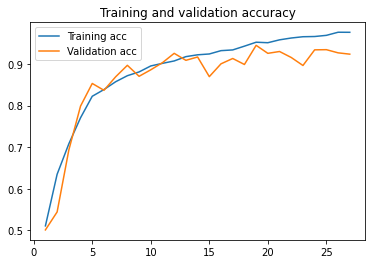

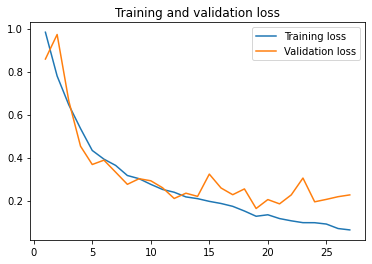

In [23]:
draw_train_graph(history)

<a name="3.1.4"></a>

### test results

In [25]:
model1.evaluate(x_test,y_test)

79/79 [==============================] - 8s 79ms/step - loss: 0.1900 - accuracy: 0.9382


[0.1899649053812027, 0.93824702501297]

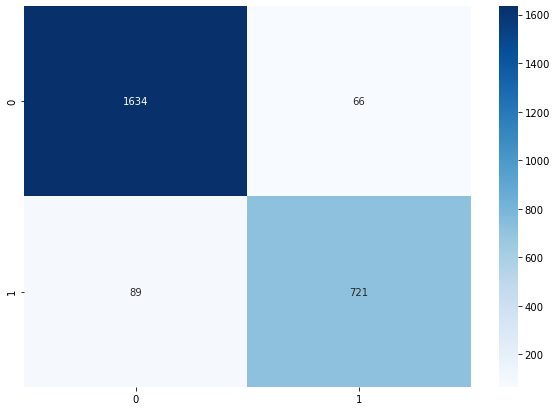

In [33]:
y_pred= model1.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [35]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.95      0.96      0.95      1700
      normal       0.92      0.89      0.90       810

    accuracy                           0.94      2510
   macro avg       0.93      0.93      0.93      2510
weighted avg       0.94      0.94      0.94      2510



In [37]:
f1_score(y_test,y_pred_rounded)

0.9029430181590482

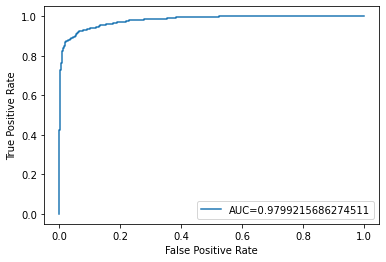

In [38]:
draw_roc(y_test,y_pred)

In [28]:
model1.save('inception_V3_model/inc_model1_acc93.h5')

<a name="3.2"></a>

### model on oversampled data

In [39]:
train_path='D:/projects data/leukemia/oversampled'

In [40]:
train_generator,valid_generator = create_generators(train_path)

Found 10188 images belonging to 2 classes.
Found 3394 images belonging to 2 classes.


<a name="3.2.1"></a>

### build the model

In [41]:
model2=build_model()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

 batch_normalization_195 (Batch  (None, 25, 25, 64)  192         ['conv2d_193[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_197 (Batch  (None, 25, 25, 64)  192         ['conv2d_195[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_200 (Batch  (None, 25, 25, 96)  288         ['conv2d_198[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_201 (Batch  (None, 25, 25, 32)  96          ['conv2d_199[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_212 (Batch  (None, 25, 25, 64)  192         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_210 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_212[0][0]']
                                                                                                  
 conv2d_208 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_211 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_210[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_214[0][0]',         
                                                                  'activation_217[0][0]',         
                                                                  'max_pooling2d_10[0][0]']       
                                                                                                  
 conv2d_222 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_nor

                                                                  'activation_226[0][0]',         
                                                                  'activation_227[0][0]']         
                                                                                                  
 conv2d_232 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_234 (Batch  (None, 12, 12, 160)  480        ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_234[0][0]']
                                                                                                  
 conv2d_23

 batch_normalization_244 (Batch  (None, 12, 12, 160)  480        ['conv2d_242[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_244[0][0]']
                                                                                                  
 conv2d_243 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_245 (Batch  (None, 12, 12, 160)  480        ['conv2d_243[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_253 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_255 (Batch  (None, 12, 12, 192)  576        ['conv2d_253[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_255[0][0]']
                                                                                                  
 conv2d_249 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_254 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_253[0][0]']         
          

 activation_261 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_263[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_262 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_261[0][0]']         
                                                                                                  
 batch_normalization_260 (Batch  (None, 12, 12, 192)  576        ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_264 (Batch  (None, 12, 12, 192)  576        ['conv2d_262[0][0]']             
 Normaliza

 conv2d_272 (Conv2D)            (None, 5, 5, 192)    245760      ['average_pooling2d_25[0][0]']   
                                                                                                  
 batch_normalization_266 (Batch  (None, 5, 5, 320)   960         ['conv2d_264[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_266 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_268[0][0]']
                                                                                                  
 activation_267 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_269[0][0]']
                                                                                                  
 activation_270 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_272[0][0]']
          

<a name="3.2.2"></a>

### model complie & train

In [42]:
history= train_model(model2 ,train_generator ,valid_generator)

Epoch 1/40
637/637 [==============================] - 528s 821ms/step - loss: 1.1501 - accuracy: 0.4523 - val_loss: 1.2603 - val_accuracy: 0.3368 - lr: 1.0000e-08
Epoch 2/40
637/637 [==============================] - 135s 212ms/step - loss: 0.6534 - accuracy: 0.7059 - val_loss: 0.4045 - val_accuracy: 0.8047 - lr: 1.5005e-05
Epoch 3/40
637/637 [==============================] - 137s 214ms/step - loss: 0.5249 - accuracy: 0.7714 - val_loss: 0.3112 - val_accuracy: 0.8459 - lr: 3.0000e-05
Epoch 4/40
637/637 [==============================] - 137s 215ms/step - loss: 0.4042 - accuracy: 0.8190 - val_loss: 0.2494 - val_accuracy: 0.8916 - lr: 3.0000e-05
Epoch 5/40
637/637 [==============================] - 137s 215ms/step - loss: 0.3502 - accuracy: 0.8485 - val_loss: 0.2420 - val_accuracy: 0.9034 - lr: 2.9946e-05
Epoch 6/40
637/637 [==============================] - 138s 216ms/step - loss: 0.3209 - accuracy: 0.8664 - val_loss: 0.1489 - val_accuracy: 0.9467 - lr: 2.9784e-05
Epoch 7/40
637/637 [==

<a name="3.2.3"></a>

### train & validation loss and accuracy per epochs

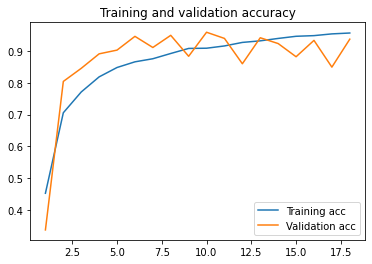

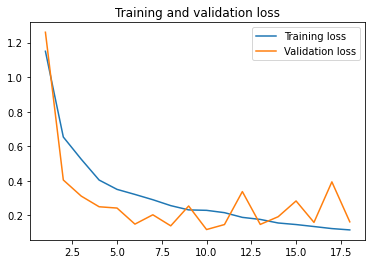

In [43]:
draw_train_graph(history)

<a name="3.2.4"></a>

### test results

In [44]:
model2.evaluate(x_test,y_test)

79/79 [==============================] - 7s 73ms/step - loss: 0.1811 - accuracy: 0.9287


[0.1810808926820755, 0.9286852478981018]

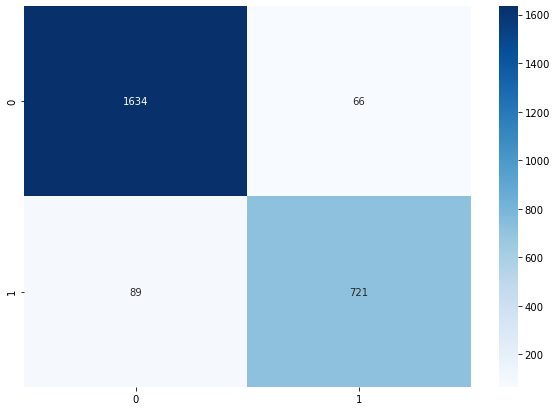

In [47]:
y_pred= model1.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [48]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.95      0.96      0.95      1700
      normal       0.92      0.89      0.90       810

    accuracy                           0.94      2510
   macro avg       0.93      0.93      0.93      2510
weighted avg       0.94      0.94      0.94      2510



In [7]:
f1_score(y_test,y_pred_rounded)

0.8924924924924924

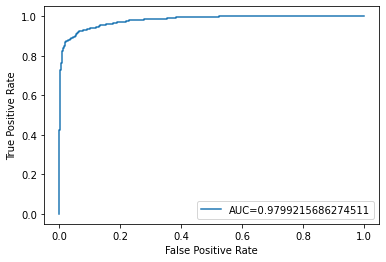

In [49]:
draw_roc(y_test,y_pred)

In [50]:
model2.save('inception_V3_model/inc_model2_acc94.h5')

<a name="3.3"></a>

### model on undersampled data

In [51]:
train_path='D:/projects data/leukemia/undersampled'

In [52]:
train_generator,valid_generator = create_generators(train_path)

Found 4842 images belonging to 2 classes.
Found 1612 images belonging to 2 classes.


<a name="3.3.1"></a>

### build the model

In [53]:
model3=build_model()

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_285 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                           

 conv2d_293 (Conv2D)            (None, 25, 25, 32)   6144        ['average_pooling2d_27[0][0]']   
                                                                                                  
 batch_normalization_290 (Batch  (None, 25, 25, 64)  192         ['conv2d_287[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_292 (Batch  (None, 25, 25, 64)  192         ['conv2d_289[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_295 (Batch  (None, 25, 25, 96)  288         ['conv2d_292[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_304 (Conv2D)            (None, 25, 25, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_307 (Batch  (None, 25, 25, 64)  192         ['conv2d_304[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_304 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_307[0][0]']
                                                                                                  
 conv2d_302 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_30

                                                                                                  
 activation_311 (Activation)    (None, 12, 12, 96)   0           ['batch_normalization_314[0][0]']
                                                                                                  
 max_pooling2d_14 (MaxPooling2D  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_308[0][0]',         
                                                                  'activation_311[0][0]',         
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_31

 mixed4 (Concatenate)           (None, 12, 12, 768)  0           ['activation_312[0][0]',         
                                                                  'activation_315[0][0]',         
                                                                  'activation_320[0][0]',         
                                                                  'activation_321[0][0]']         
                                                                                                  
 conv2d_326 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_329 (Batch  (None, 12, 12, 160)  480        ['conv2d_326[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_336 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_339 (Batch  (None, 12, 12, 160)  480        ['conv2d_336[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_336 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_339[0][0]']
                                                                                                  
 conv2d_337 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_336[0][0]']         
                                                                                                  
 batch_normalization_340 (Batch  (None, 12, 12, 160)  480        ['conv2d_337[0][0]']             
 Normaliza

 activation_346 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_349[0][0]']
                                                                                                  
 conv2d_347 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_346[0][0]']         
                                                                                                  
 batch_normalization_350 (Batch  (None, 12, 12, 192)  576        ['conv2d_347[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_347 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_350[0][0]']
                                                                                                  
 conv2d_343 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
          

 Normalization)                                                                                   
                                                                                                  
 activation_355 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_358[0][0]']
                                                                                                  
 conv2d_352 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_356 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_355[0][0]']         
                                                                                                  
 batch_normalization_355 (Batch  (None, 12, 12, 192)  576        ['conv2d_352[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 conv2d_366 (Conv2D)            (None, 5, 5, 192)    245760      ['average_pooling2d_34[0][0]']   
                                                                                                  
 batch_normalization_361 (Batch  (None, 5, 5, 320)   960         ['conv2d_358[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_360 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_363[0][0]']
                                                                                                  
 activation_361 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_364[0][0]']
          

<a name="3.3.2"></a>

### model complie & train

In [54]:
history=train_model(model3,train_generator,valid_generator)

Epoch 1/40
303/303 [==============================] - 231s 744ms/step - loss: 1.0035 - accuracy: 0.5010 - val_loss: 0.8169 - val_accuracy: 0.5292 - lr: 1.0000e-08
Epoch 2/40
303/303 [==============================] - 79s 259ms/step - loss: 0.8245 - accuracy: 0.6084 - val_loss: 0.6468 - val_accuracy: 0.6818 - lr: 1.5005e-05
Epoch 3/40
303/303 [==============================] - 83s 271ms/step - loss: 0.7435 - accuracy: 0.6594 - val_loss: 0.5508 - val_accuracy: 0.7395 - lr: 3.0000e-05
Epoch 4/40
303/303 [==============================] - 86s 283ms/step - loss: 0.6353 - accuracy: 0.7243 - val_loss: 0.4789 - val_accuracy: 0.7773 - lr: 3.0000e-05
Epoch 5/40
303/303 [==============================] - 102s 335ms/step - loss: 0.5498 - accuracy: 0.7588 - val_loss: 0.3879 - val_accuracy: 0.8313 - lr: 2.9946e-05
Epoch 6/40
303/303 [==============================] - 80s 262ms/step - loss: 0.4762 - accuracy: 0.7898 - val_loss: 0.3670 - val_accuracy: 0.8288 - lr: 2.9784e-05
Epoch 7/40
303/303 [======

Epoch 34/40
303/303 [==============================] - 58s 191ms/step - loss: 0.0837 - accuracy: 0.9713 - val_loss: 0.1950 - val_accuracy: 0.9311 - lr: 2.5724e-06


<a name="3.3.3"></a>

### train & validation loss and accuracy per epochs

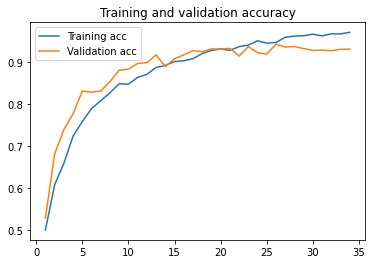

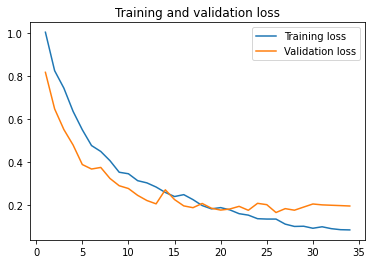

In [55]:
draw_train_graph(history)

<a name="3.3.4"></a>

### test results

In [14]:
model3.evaluate(x_test,y_test)

79/79 [==============================] - 7s 72ms/step - loss: 0.2313 - accuracy: 0.9191


[0.23126231133937836, 0.9191235303878784]

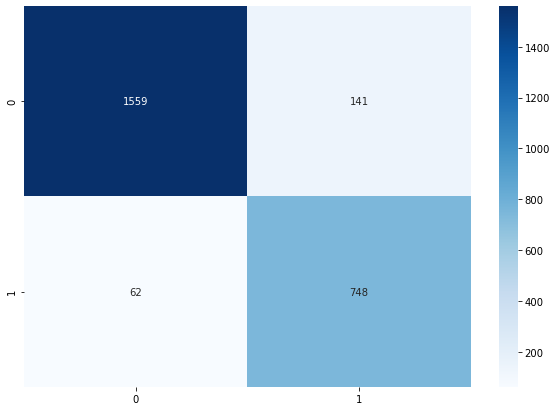

In [10]:
y_pred= model3.predict(x_test)
y_pred_rounded = draw_confusion_matrix(y_test ,y_pred)

In [11]:
print_classification_report(y_test,  y_pred_rounded)

              precision    recall  f1-score   support

    abnormal       0.96      0.92      0.94      1700
      normal       0.84      0.92      0.88       810

    accuracy                           0.92      2510
   macro avg       0.90      0.92      0.91      2510
weighted avg       0.92      0.92      0.92      2510



In [15]:
f1_score(y_test,y_pred_rounded)

0.8805179517363155

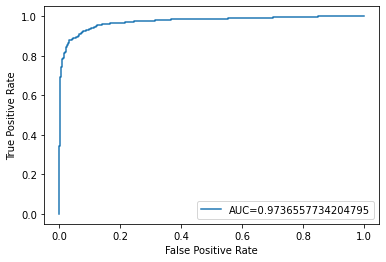

In [15]:
draw_roc(y_test,y_pred)

In [16]:
model3.save('inception_V3_model/inc_model3_acc92.h5')